## API로 캐글 데이터 다운 받기
API : Application Programming Interface

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 캐글에 로그인 후 api json 파일 받아서 여기에 올리기
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"semi0612","key":"2e0c4532a808baddff94416c4916bd77"}'}

In [ ]:
# 코랩 내에 파일 만들고 json 파일 저장
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 캐글에 접근하여 dog vs cats 가져오기

!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:03<00:00, 231MB/s]
100% 812M/812M [00:03<00:00, 264MB/s]


In [ ]:
# 가져온 데이터 확인
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [ ]:
# zip 형태로 가져왔으니 unzip 시키기
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [ ]:
!ls

dogs-vs-cats.zip  sample_data		test1.zip  train.zip
kaggle.json	  sampleSubmission.csv	train


## pathlib 모듈로 파일 정리
- pathlib
  - 파일, 디렉토리(폴더)의 경로를 객체로써 조작하거나 처리.
  - 파일명 혹은 부모 디렉토리를 알아내거나 경로의 목록을 얻어내거나, 파일을 작성하거나 삭제하는 등 대략적인 파일 관련 처리가 가능하다

모듈을 사용하여 총 25000개의 cat_dog 이미지들을 5000개의 mini dataset으로 만들어 줄것이다.

- mini dataset으로 하는 이유
  - 빠르게 실행결과를 확인하고 비교해 보기 위하여
  - '케라스 창시자에게 배우는 딥러닝(개정 2판)' 속 '많은 데이터가 있으면 문제가 더 쉬워집니다. 따라서 배울 때는 작은 데이터 셋을 사용하는 것이 좋습니다' 의 문구를 보고 

In [ ]:
# 이미지를 훈련, 검증, 테스트 디렉터리로 복사하기
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cat_vs_dogs_small")

def make_subset(subset_name, start_index, end_index) :
  for category in ("cat", "dog") :
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    for fname in fnames :
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 이미지 갯수 확인 및 전처리 하여 불러들이기
데이터는 네트워크에 주입되기 전 부동 소수점 타입의 텐서로 적절하게 전처리되어 있어야한다. 지금은 데이터가 JPEG 파일로 되어있으므로 네트워크에 주입하려면 대략 아래와 같은 과정을 거쳐야한다.
1. 사진파일을 읽는다
2. JPEG 파일을 RGB 픽셀 값으로 디코딩한다
3. 부동 소수점 타입의 텐서로 변환한다
4. 동일한 크기의 이미지로 변환한다. 여기서는 (180, 180)
5. 배치로 묶는다. 여기서는 (하나의 배치 = 32) 개로 지정해줄 것이다.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
import os

PATH = "/content/cat_vs_dogs_small"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 모델 7가지
- 비교할 모델 7가지
  - VGG16, VGG19, Inception_v3(GoogleNet), ResNet, Xception, MobileNet, DenseNet
- 비교할 것
  - [ train loss - validation loss / train accaurcy - validation accaurcy ] 그래프<br>
  - confusion metrics
- EarlyStopping callbacks는 사용(단, 동일 설정)
- 모델을 불러와 추가할 모델 코드/compile 설정은 아래와 동일할 것이다

```python
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = '불러온 모델'(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
'새로 생성된 모델 명' = keras.Model(inputs, outputs)


'새로 생성된 모델 명'.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')
```

## VGG16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

vgg16_net_catdog = VGG16(include_top = False, weights='imagenet')
vgg16_net_catdog.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_net_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
vgg16_net_catdog = keras.Model(inputs, outputs)


vgg16_net_catdog.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


vgg16_net_catdog.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               327705

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_vgg16.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = vgg16_net_catdog.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 23s 219ms/step - loss: 22.1752 - acc: 0.9225 - val_loss: 4.1088 - val_acc: 0.9690
Epoch 2/50
63/63 [==============================] - 11s 172ms/step - loss: 3.3175 - acc: 0.9770 - val_loss: 5.5970 - val_acc: 0.9660
Epoch 3/50
63/63 [==============================] - 11s 177ms/step - loss: 2.7561 - acc: 0.9800 - val_loss: 12.4758 - val_acc: 0.9490
Epoch 4/50
63/63 [==============================] - 12s 181ms/step - loss: 1.3083 - acc: 0.9885 - val_loss: 3.6476 - val_acc: 0.9770
Epoch 5/50
63/63 [==============================] - 11s 176ms/step - loss: 1.2680 - acc: 0.9915 - val_loss: 6.6735 - val_acc: 0.9640
Epoch 6/50
63/63 [==============================] - 11s 175ms/step - loss: 1.0949 - acc: 0.9925 - val_loss: 8.6826 - val_acc: 0.9690
Epoch 7/50
63/63 [==============================] - 11s 172ms/step - loss: 0.8784 - acc: 0.9925 - val_loss: 4.4602 - val_acc: 0.9750
Epoch 8/50
63/63 [==============================] - 12s 181ms/step 

### 시각화

In [ ]:
test_loss, test_acc = vgg16_net_catdog.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 7s 115ms/step - loss: 6.8794 - acc: 0.9730
테스트 정확도 : 0.973


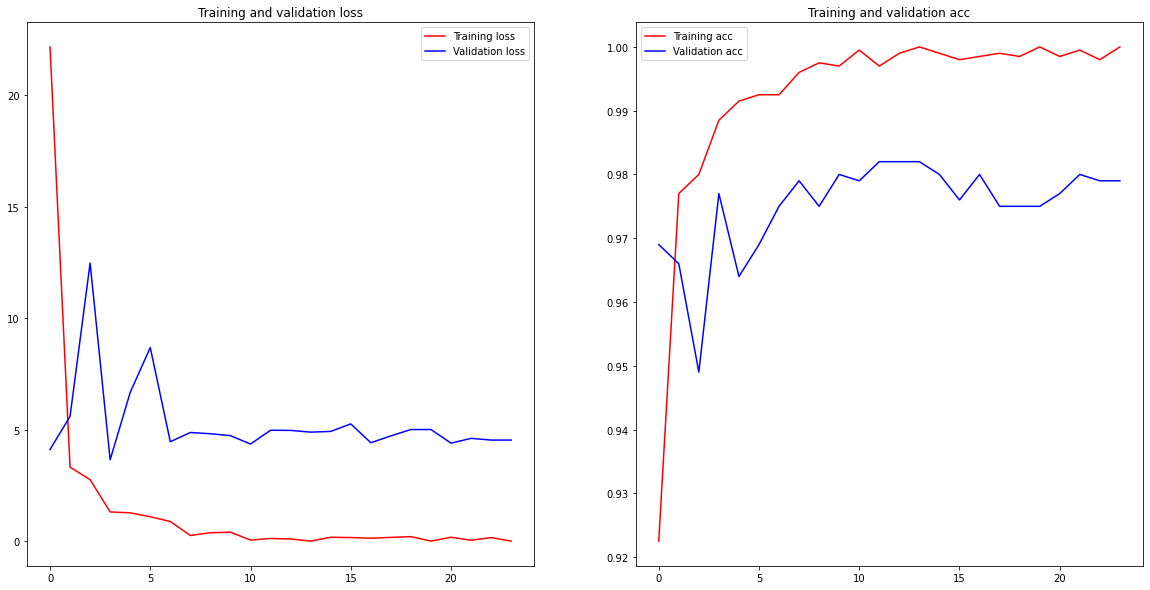

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confusion matrix

In [ ]:
print("Predict")
pred = vgg16_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-16-38f8ba6bd680>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = vgg16_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 15s

200/200 [==============================] - 7s 35ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

In [ ]:
import tensorflow as tf
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

<tf.Tensor: shape=(2000,), dtype=int32, numpy=array([1, 0, 1, ..., 0, 1, 1], dtype=int32)>

Confusion Matrix


Text(33.0, 0.5, 'true value')

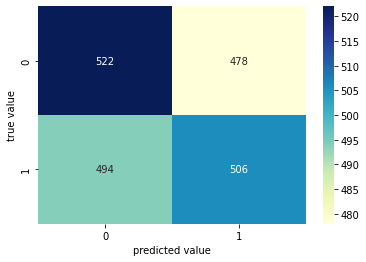

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.973)
- 중간에 EarlyStopping 작동. 24에폭 훈련

## VGG19

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

vgg19_net_catdog = VGG19(include_top = False, weights='imagenet')
vgg19_net_catdog.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = vgg19_net_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
vgg19_net_catdog = keras.Model(inputs, outputs)


vgg19_net_catdog.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


vgg19_net_catdog.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_vgg19.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = vgg19_net_catdog.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 13s 209ms/step - loss: 0.0633 - acc: 0.9980 - val_loss: 5.0834 - val_acc: 0.9750
Epoch 2/50
63/63 [==============================] - 13s 207ms/step - loss: 0.1058 - acc: 0.9980 - val_loss: 5.5181 - val_acc: 0.9760
Epoch 3/50
63/63 [==============================] - 13s 212ms/step - loss: 0.4228 - acc: 0.9925 - val_loss: 4.9244 - val_acc: 0.9730
Epoch 4/50
63/63 [==============================] - 13s 209ms/step - loss: 0.0774 - acc: 0.9990 - val_loss: 4.5852 - val_acc: 0.9760
Epoch 5/50
63/63 [==============================] - 13s 203ms/step - loss: 8.8083e-10 - acc: 1.0000 - val_loss: 4.5990 - val_acc: 0.9760
Epoch 6/50
63/63 [==============================] - 13s 211ms/step - loss: 0.0862 - acc: 0.9990 - val_loss: 4.3581 - val_acc: 0.9770
Epoch 7/50
63/63 [==============================] - 13s 208ms/step - loss: 4.4106e-07 - acc: 1.0000 - val_loss: 9.0806 - val_acc: 0.9610
Epoch 8/50
63/63 [==============================] - 13s 212ms

In [ ]:
test_loss, test_acc = vgg19_net_catdog.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 9s 135ms/step - loss: 5.0302 - acc: 0.9805
테스트 정확도 : 0.980


### 시각화

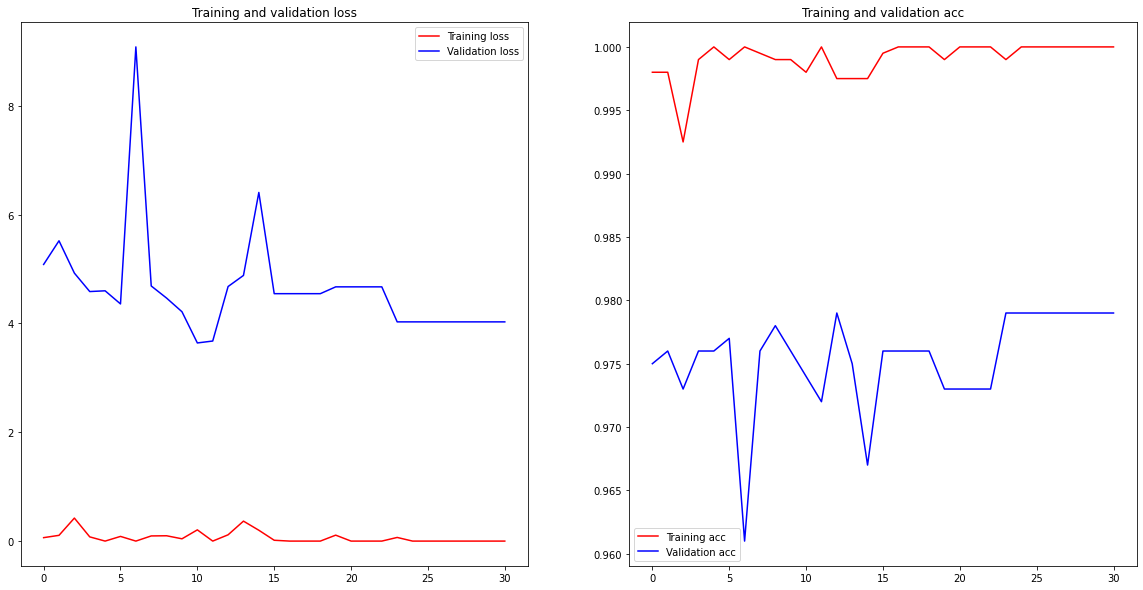

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confusion matrix

In [ ]:
print("Predict")
pred = vgg19_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-28-9f33d6bef1f7>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = vgg19_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 17s

200/200 [==============================] - 9s 41ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

In [ ]:
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

<tf.Tensor: shape=(2000,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0], dtype=int32)>

Confusion Matrix


Text(33.0, 0.5, 'true value')

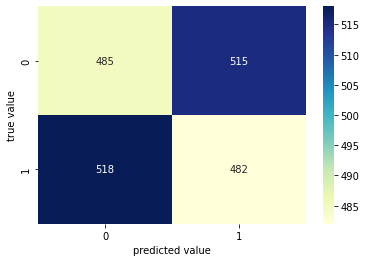

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.980)
- 중간에 EarlyStopping 작동. 31에폭 훈련

## inception_v3(GoogleNet)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

inception_catdog = InceptionV3(include_top=False, weights='imagenet')
inception_catdog.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = inception_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
inception_v3_net_catdog = keras.Model(inputs, outputs)


inception_v3_net_catdog.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


inception_v3_net_catdog.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_inception_v3.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = inception_v3_net_catdog.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 13s 134ms/step - loss: 12.5866 - acc: 0.9210 - val_loss: 32.4154 - val_acc: 0.7320
Epoch 2/50
63/63 [==============================] - 6s 94ms/step - loss: 6.0362 - acc: 0.9635 - val_loss: 2.5368 - val_acc: 0.9810
Epoch 3/50
63/63 [==============================] - 6s 86ms/step - loss: 2.3439 - acc: 0.9785 - val_loss: 2.8787 - val_acc: 0.9820
Epoch 4/50
63/63 [==============================] - 5s 85ms/step - loss: 2.3961 - acc: 0.9840 - val_loss: 6.7380 - val_acc: 0.9680
Epoch 5/50
63/63 [==============================] - 6s 86ms/step - loss: 1.3815 - acc: 0.9855 - val_loss: 3.0753 - val_acc: 0.9790
Epoch 6/50
63/63 [==============================] - 5s 85ms/step - loss: 1.0073 - acc: 0.9910 - val_loss: 3.7616 - val_acc: 0.9820
Epoch 7/50
63/63 [==============================] - 6s 85ms/step - loss: 0.6116 - acc: 0.9920 - val_loss: 4.0005 - val_acc: 0.9810
Epoch 8/50
63/63 [==============================] - 5s 84ms/step - loss: 0.6123

In [ ]:
test_loss, test_acc = inception_v3_net_catdog.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 4s 55ms/step - loss: 3.6335 - acc: 0.9820
테스트 정확도 : 0.982


### 시각화

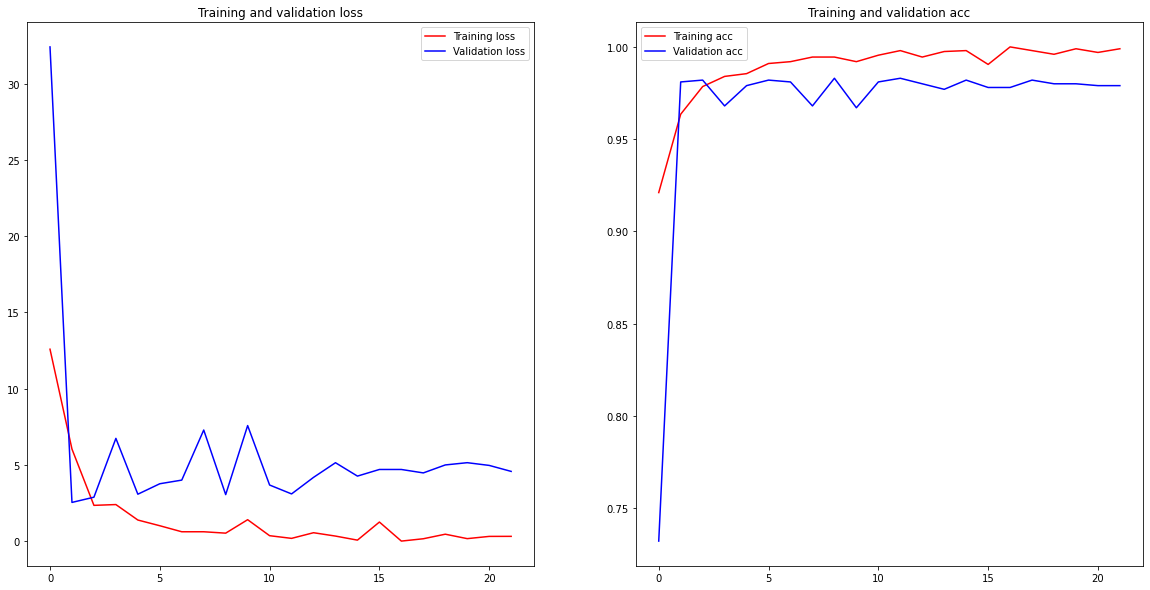

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confustion matrix




In [ ]:
print("Predict")
pred = inception_v3_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-38-aa74c3d07ac9>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = inception_v3_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 7s

200/200 [==============================] - 5s 17ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

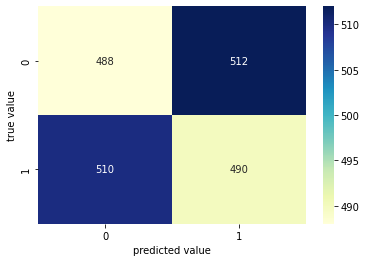

In [ ]:
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.982)
- 중간에 EarlyStopping 작동. 22에폭 훈련

## ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

resnet50_net = ResNet50(include_top = False, weights = 'imagenet', input_shape=(180, 180, 3))
resnet50_net.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = resnet50_net(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
resnet50_net_catdog = keras.Model(inputs, outputs)


resnet50_net_catdog.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


resnet50_net_catdog.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               1887

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_resnet50.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = resnet50_net_catdog.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 13s 156ms/step - loss: 19.2767 - acc: 0.9245 - val_loss: 4.0692 - val_acc: 0.9680
Epoch 2/50
63/63 [==============================] - 8s 122ms/step - loss: 1.8848 - acc: 0.9840 - val_loss: 12.8451 - val_acc: 0.9470
Epoch 3/50
63/63 [==============================] - 8s 126ms/step - loss: 1.7175 - acc: 0.9855 - val_loss: 7.2315 - val_acc: 0.9690
Epoch 4/50
63/63 [==============================] - 8s 124ms/step - loss: 1.7909 - acc: 0.9900 - val_loss: 6.1113 - val_acc: 0.9720
Epoch 5/50
63/63 [==============================] - 9s 135ms/step - loss: 0.6818 - acc: 0.9920 - val_loss: 3.7507 - val_acc: 0.9750
Epoch 6/50
63/63 [==============================] - 8s 121ms/step - loss: 1.1666 - acc: 0.9925 - val_loss: 4.7235 - val_acc: 0.9760
Epoch 7/50
63/63 [==============================] - 8s 120ms/step - loss: 0.3612 - acc: 0.9980 - val_loss: 4.5590 - val_acc: 0.9770
Epoch 8/50
63/63 [==============================] - 8s 120ms/step - loss:

In [ ]:
test_loss, test_acc = resnet50_net_catdog.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 5s 75ms/step - loss: 4.4715 - acc: 0.9825
테스트 정확도 : 0.983


### 시각화

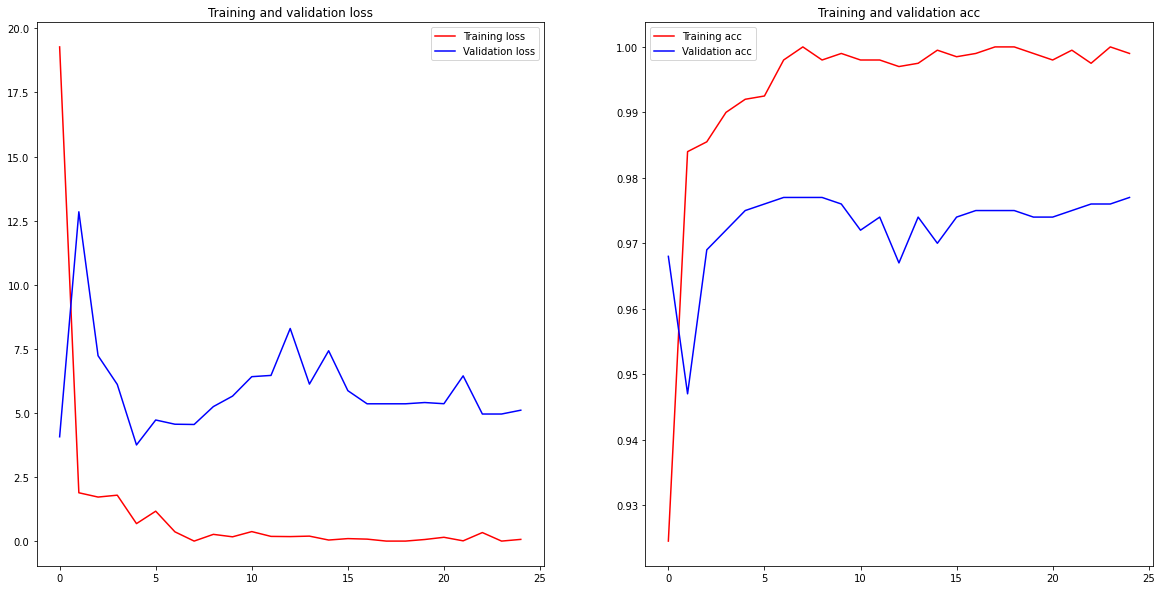

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confustion matrix

In [ ]:
print("Predict")
pred = resnet50_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-52-88731147216c>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = resnet50_net_catdog.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 9s 

200/200 [==============================] - 6s 23ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

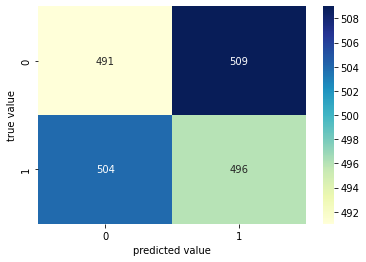

In [ ]:
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.983)
- 중간에 EarlyStopping 작동. 26에폭 훈련

## Xception

In [ ]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

xception_catdog = Xception(include_top=False, weights='imagenet')
xception_catdog.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = xception_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
xception_catdog_net = keras.Model(inputs, outputs)


xception_catdog_net.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


xception_catdog_net.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               1887

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_xception_catdog_net.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = xception_catdog_net.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 15s 183ms/step - loss: 4.8436 - acc: 0.9500 - val_loss: 2.0598 - val_acc: 0.9670
Epoch 2/50
63/63 [==============================] - 10s 151ms/step - loss: 1.9518 - acc: 0.9760 - val_loss: 2.8719 - val_acc: 0.9600
Epoch 3/50
63/63 [==============================] - 9s 148ms/step - loss: 1.4029 - acc: 0.9840 - val_loss: 2.8153 - val_acc: 0.9780
Epoch 4/50
63/63 [==============================] - 9s 144ms/step - loss: 1.0083 - acc: 0.9875 - val_loss: 2.3272 - val_acc: 0.9780
Epoch 5/50
63/63 [==============================] - 10s 153ms/step - loss: 0.7958 - acc: 0.9905 - val_loss: 2.0006 - val_acc: 0.9860
Epoch 6/50
63/63 [==============================] - 9s 140ms/step - loss: 0.4608 - acc: 0.9915 - val_loss: 2.3566 - val_acc: 0.9840
Epoch 7/50
63/63 [==============================] - 9s 140ms/step - loss: 0.4143 - acc: 0.9960 - val_loss: 2.4180 - val_acc: 0.9850
Epoch 8/50
63/63 [==============================] - 9s 141ms/step - loss:

In [ ]:
test_loss, test_acc = xception_catdog_net.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 6s 90ms/step - loss: 2.9610 - acc: 0.9820
테스트 정확도 : 0.982


### 시각화

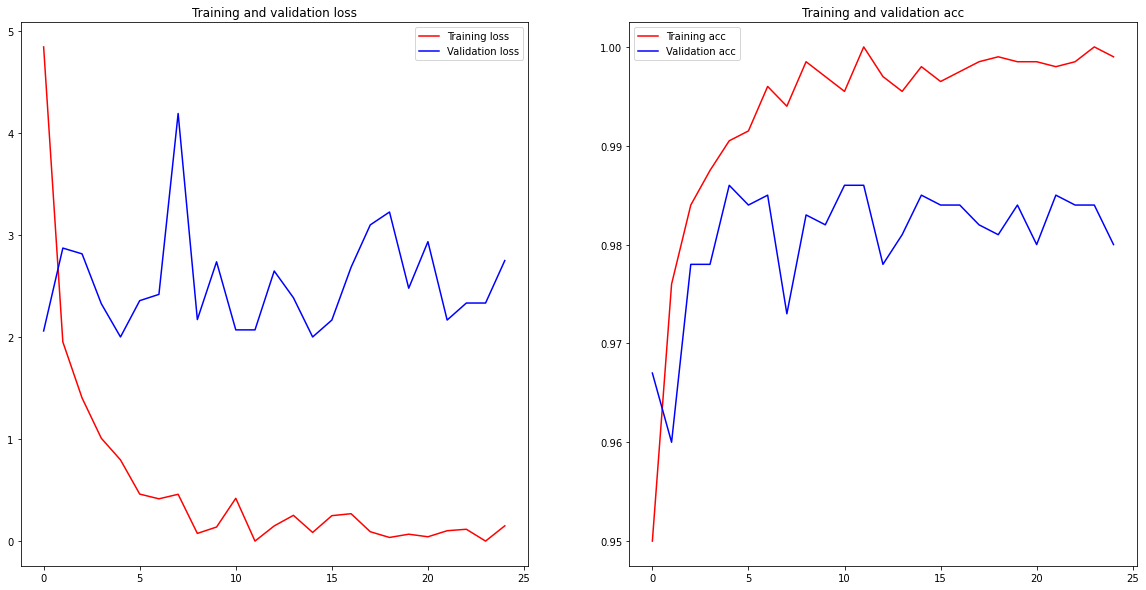

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confustion matrix

In [ ]:
print("Predict")
pred = xception_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-61-2f270d4aff9e>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = xception_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 12s

200/200 [==============================] - 6s 28ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

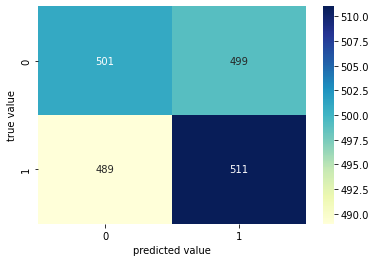

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.982)
- 중간에 EarlyStopping 작동 . 25에폭 훈련

## MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

mobilenet_catdog = MobileNet(include_top=False, weights='imagenet')
mobilenet_catdog.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.mobilenet.preprocess_input(inputs)
x = mobilenet_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
mobilenet_catdog_net = keras.Model(inputs, outputs)


mobilenet_catdog_net.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


mobilenet_catdog_net.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 25600)             0         
                                                           

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_mobilenet_catdog_net.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = mobilenet_catdog_net.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 6s 65ms/step - loss: 10.2531 - acc: 0.9165 - val_loss: 0.7580 - val_acc: 0.9830
Epoch 2/50
63/63 [==============================] - 3s 47ms/step - loss: 2.6329 - acc: 0.9780 - val_loss: 3.6810 - val_acc: 0.9660
Epoch 3/50
63/63 [==============================] - 3s 47ms/step - loss: 1.1277 - acc: 0.9875 - val_loss: 1.2057 - val_acc: 0.9800
Epoch 4/50
63/63 [==============================] - 3s 47ms/step - loss: 1.2876 - acc: 0.9860 - val_loss: 2.0461 - val_acc: 0.9770
Epoch 5/50
63/63 [==============================] - 4s 55ms/step - loss: 0.5315 - acc: 0.9925 - val_loss: 1.1756 - val_acc: 0.9860
Epoch 6/50
63/63 [==============================] - 3s 52ms/step - loss: 0.6047 - acc: 0.9935 - val_loss: 2.3398 - val_acc: 0.9760
Epoch 7/50
63/63 [==============================] - 3s 51ms/step - loss: 0.5951 - acc: 0.9925 - val_loss: 1.8114 - val_acc: 0.9850
Epoch 8/50
63/63 [==============================] - 3s 50ms/step - loss: 0.1248 - 

In [ ]:
test_loss, test_acc = mobilenet_catdog_net.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 2s 29ms/step - loss: 2.7539 - acc: 0.9800
테스트 정확도 : 0.980


### 시각화

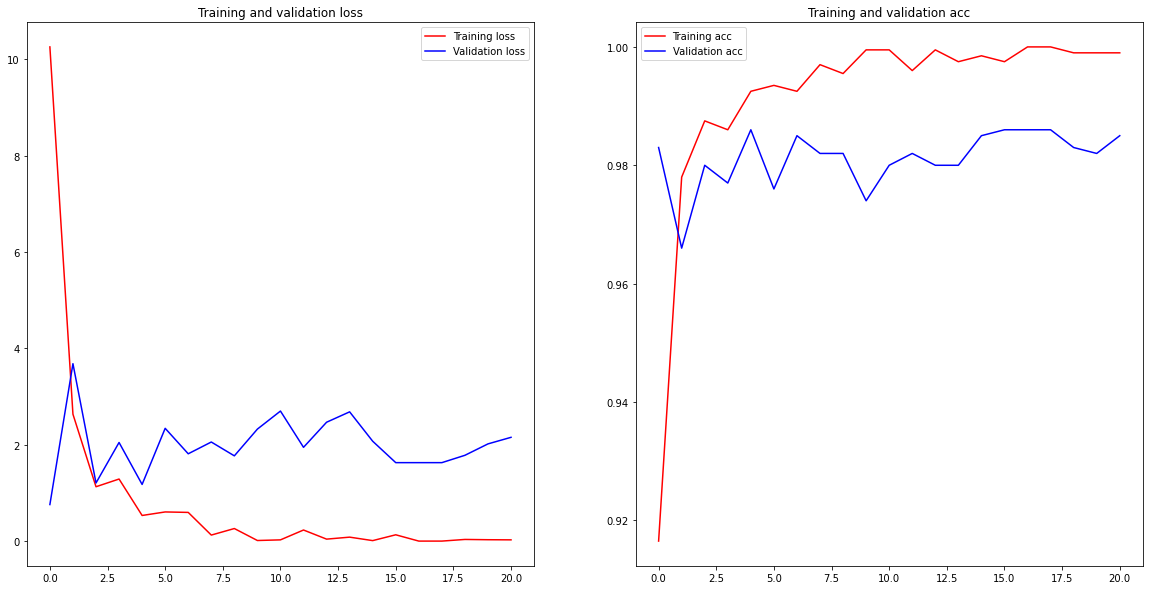

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confustion matrix

In [ ]:
print("Predict")
pred = mobilenet_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-69-dd372ae1470a>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = mobilenet_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)


 62/200 [========>.....................] - ETA: 4s

200/200 [==============================] - 3s 11ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

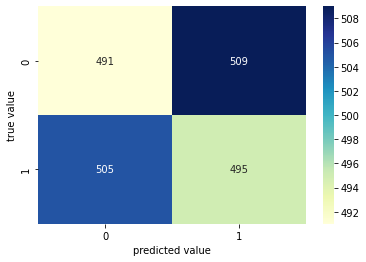

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.980)
- 중간에 EarlyStopping 작동. 21에폭 훈련

## Densenet

In [ ]:
from keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions

densenet_catdog = DenseNet201(include_top=False, weights='imagenet')
densenet_catdog.trainable = False

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.densenet.preprocess_input(inputs)
x = densenet_catdog(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
densenet_catdog_net = keras.Model(inputs, outputs)


densenet_catdog_net.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics='acc')


densenet_catdog_net.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                           

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_densenet_catdog_net.keras',
        save_best_only = True,
        moniter='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='auto'
    )
]

history = densenet_catdog_net.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 30s 283ms/step - loss: 11.1563 - acc: 0.9365 - val_loss: 0.4618 - val_acc: 0.9890
Epoch 2/50
63/63 [==============================] - 11s 168ms/step - loss: 2.3374 - acc: 0.9785 - val_loss: 1.0614 - val_acc: 0.9900
Epoch 3/50
63/63 [==============================] - 11s 169ms/step - loss: 1.3847 - acc: 0.9855 - val_loss: 0.9063 - val_acc: 0.9900
Epoch 4/50
63/63 [==============================] - 11s 169ms/step - loss: 0.6325 - acc: 0.9930 - val_loss: 0.8849 - val_acc: 0.9900
Epoch 5/50
63/63 [==============================] - 11s 165ms/step - loss: 0.3970 - acc: 0.9940 - val_loss: 1.1200 - val_acc: 0.9910
Epoch 6/50
63/63 [==============================] - 11s 165ms/step - loss: 0.3822 - acc: 0.9925 - val_loss: 1.5261 - val_acc: 0.9880
Epoch 7/50
63/63 [==============================] - 10s 163ms/step - loss: 0.3954 - acc: 0.9960 - val_loss: 0.9891 - val_acc: 0.9910
Epoch 8/50
63/63 [==============================] - 10s 164ms/step -

In [ ]:
test_loss, test_acc = densenet_catdog_net.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

63/63 [==============================] - 7s 106ms/step - loss: 1.9418 - acc: 0.9875
테스트 정확도 : 0.988


### 시각화

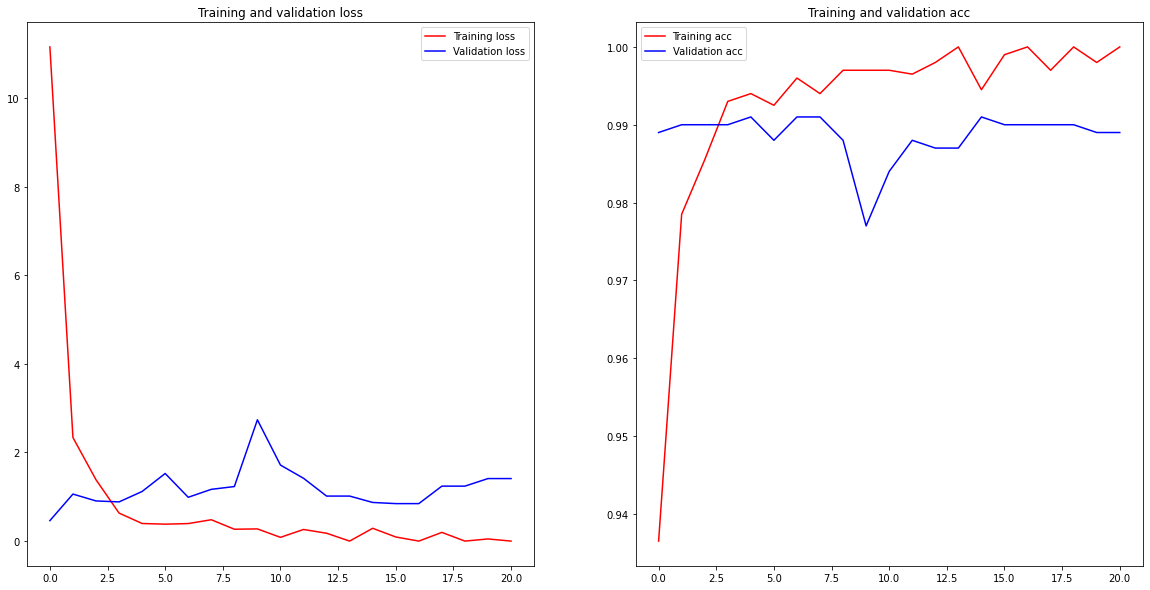

In [ ]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation acc')
axs[1].legend(loc=0)

#### confustion matrix

In [ ]:
print("Predict")
pred = densenet_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)

Predict


<ipython-input-77-a0f909f98a72>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = densenet_catdog_net.predict_generator(test_dataset, steps=200, verbose=1)


 63/200 [========>.....................] - ETA: 14s

200/200 [==============================] - 9s 32ms/step


In [ ]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

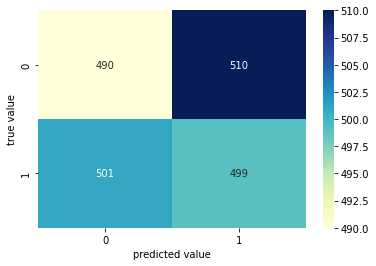

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

true_categories = tf.concat([y for x, y in test_dataset], axis=0)
true_categories

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(true_categories, predict_data4)
#print(conf_matrix)

sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

### 사용 결과 (테스트 정확도 : 0.988)
- 중간에 EarlyStopping 작동. 21에폭 훈련

## 결과적으로
다 정확도가 꽤 높게 나온것 같다. 